# Lane Detection Using Semantic Segmentation

The purpose of the code is to create an effective lane marking algorithm that can be used by an autonomous vehicle so that it can understand the content in the images and thius make informed decisions.

**ENet** was chosen as the algorithm for the purpose becuase it claims to provide the same accuracy as well known models such as FCN and UNet while having 2 orers less of trainabel parameters.

Two models are created with the same Enet architecture:

-  One is trained on RGB images
-  The other is trained on Canny Equivalent of images. This has been done to reduce the information that the model needs to process.

### Installation of the required libraries and Import of the same

In [1]:
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install bezier

In [2]:
import json
from pprint import pprint
import matplotlib.pyplot as plt
% matplotlib inline
import cv2
import bezier
import numpy as np
import numpy
import cv2

import glob
from random import shuffle
import os
import shutil
from shutil import copy2

import itertools
import glob

from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model


from keras.optimizers import Adam, RMSprop 
from keras.metrics import binary_crossentropy
from keras.metrics import categorical_crossentropy

from keras import backend as K

import tensorflow as tf
import numpy as np

import time

## Mask Creation

To perform semantic segmentation a Mask is required that showcasese the class that every pixel in an image belongs to. 
<br> However, the Berkley dataset provides nodes for a Bezier curve. These nodes are utilized to plot a urve which in turened will be used to evaluate 10k points. Tis would let us plot the curve in pixel space.

In [4]:
#Importing the Labels file 
with open('/path to json/bdd100k_labels_images_val.json') as f:
    data = json.load(f)

In [5]:
#Extracting the vertices for lanes in every image from the poly2D key corresponding to the same

labels = []

for i in data:
    closed = []
    types = []
    vertices = []
    j = i['labels']
    for k in j:
        if k['category']=='lane':
            closed.append(k['poly2d'][0]['closed'])
            types.append(k['poly2d'][0]['types'])
            vertices.append(k['poly2d'][0]['vertices'])
    
    test = [i['name'], closed, types, vertices]
    labels.append(test)

In [7]:
# Creating a folder to store the masks
import os 
os.makedirs('/path to mask/mask/')

In [8]:
# The following code plots the vertices using the bezier curve API provided by Python
for im_idx in range(len(labels)):
    
    multi_lines_x = []
    multi_lines_y = []

    for i in labels[im_idx][3]:
        a=[]
        b=[]
        for x, y in i:
            a.append(x)
            b.append(y)

        multi_lines_x.append(a)
        multi_lines_y.append(b)
    
    kernel = np.ones((5,5),np.uint8)

    img_mask = np.zeros((len(labels[im_idx][3]),720,1280))
    
    for i in range(len(labels[im_idx][3])):
        nodes = np.asfortranarray([multi_lines_x[i], multi_lines_y[i]])
        curve = bezier.Curve(nodes, degree=len(multi_lines_x[i]))
        
        #10 k points are evcaluated on the curve which are discretized to be able to plotted on the image grid
        s_vals = np.linspace(0.0, 1.0, 1000)
        a = curve.evaluate_multi(s_vals)
        b = np.round(a[0]).astype(int)
        b=b-1
        c = np.round(a[1]).astype(int)
        c=c-1

        for j,k in zip(b,c):
            if(j==1280):
                j=j-1
            if(k==720):
                k=k-1
            img_mask[i,k,j]=255

        #the fragmented points are dilated to create a continous mask
        img_mask[i,:,:] = cv2.dilate(img_mask[i,:,:],kernel,iterations = 1)
    
    intensity = img_mask.sum(axis=0)
    intensity[intensity > 0] = 255
    cv2.imwrite( "/path to mask/mask/"+labels[im_idx][0][:-4]+".png", intensity.astype(numpy.uint8) );


#### Showcasing the effect of dilation

(-0.5, 1279.5, 719.5, -0.5)

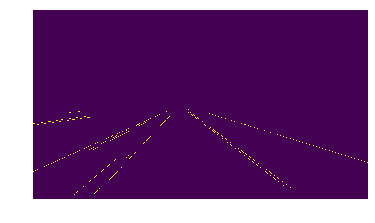

In [7]:

#The code is similr to the one in teh previous cell with the only difference that the operation has been performed for 
#just one image without dilation

im_idx = 0
multi_lines_x = []
multi_lines_y = []

for i in labels[im_idx][3]:
    a=[]
    b=[]
    for x, y in i:
        a.append(x)
        b.append(y)

    multi_lines_x.append(a)
    multi_lines_y.append(b)

kernel = np.ones((10,10),np.uint8)

img_mask = np.zeros((len(labels[im_idx][3]),720,1280))

for i in range(len(labels[im_idx][3])):
    #kernel = np.ones((5,5),np.uint8)
    nodes = np.asfortranarray([multi_lines_x[i], multi_lines_y[i]])
    curve = bezier.Curve(nodes, degree=len(multi_lines_x[i]))
    s_vals = np.linspace(0.0, 1.0, 1000)
    a = curve.evaluate_multi(s_vals)
    b = np.round(a[0]).astype(int)
    b=b-1
    c = np.round(a[1]).astype(int)
    c=c-1

    for j,k in zip(b,c):
        if(j==1280):
            j=j-1
        if(k==720):
            k=k-1
        img_mask[i,k,j]=255


intensity = img_mask.sum(axis=0)
intensity[intensity > 0] = 255
plt.imshow(intensity)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

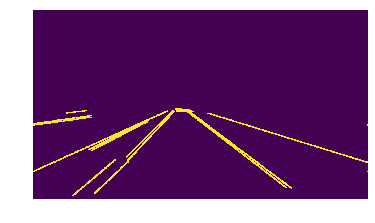

In [8]:

#The code is similr to the one in teh previous cell with the only difference that the operation has been performed for 
#just one image with dilation

im_idx = 0
multi_lines_x = []
multi_lines_y = []

for i in labels[im_idx][3]:
    a=[]
    b=[]
    for x, y in i:
        a.append(x)
        b.append(y)

    multi_lines_x.append(a)
    multi_lines_y.append(b)

kernel = np.ones((5,5),np.uint8)

img_mask = np.zeros((len(labels[im_idx][3]),720,1280))

for i in range(len(labels[im_idx][3])):
   
    nodes = np.asfortranarray([multi_lines_x[i], multi_lines_y[i]])
    curve = bezier.Curve(nodes, degree=len(multi_lines_x[i]))
    s_vals = np.linspace(0.0, 1.0, 1000)
    a = curve.evaluate_multi(s_vals)
    b = np.round(a[0]).astype(int)
    b=b-1
    c = np.round(a[1]).astype(int)
    c=c-1

    for j,k in zip(b,c):
        if(j==1280):
            j=j-1
        if(k==720):
            k=k-1
        img_mask[i,k,j]=255

    img_mask[i,:,:] = cv2.dilate(img_mask[i,:,:],kernel,iterations = 1)
intensity = img_mask.sum(axis=0)
intensity[intensity > 0] = 255
plt.imshow(intensity)
plt.axis('off')

## Data Split

The Data is split into training, testing and validation in a ratio of 0.7:0.15:0.15

In [9]:

def split_data(image_path, masks_path):
    images = glob.glob( image_path + "*.jpg"  )
    masks = glob.glob( masks_path + "*.png"  )
    images.sort()
    masks.sort()
    
    assert len( images ) == len(masks)
        
    for im , seg in zip(images,masks):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
    
    shuffle(images)
    
    directory = ['/path/train/image2', '/path/train/mask', 
                 '/path/valid/image2', '/path/valid/mask',
                '/path/test/image2', '/path/test/mask']
    
    
    for i in directory:
        if not os.path.exists(i):
            os.makedirs(i)
    
    length = len(images)
    
    train = int(0.7 * length)
    test = int(0.15 * length)
    valid  = length - train - test
    
    for i, j in enumerate(images):
        j = j.split('/')[-1].split(".")[0]
        if i <=0.7*length:
            shutil.copy2(image_path +j+".jpg", directory[0])
            shutil.move(masks_path +j+".png", directory[1])
                       
        elif i<= 0.85*length :
            shutil.copy2(image_path +j+".jpg", directory[2])
            shutil.move(masks_path +j+".png", directory[3])

        else:
            shutil.copy2(image_path +j+".jpg", directory[4])
            shutil.move(masks_path +j+".png", directory[5])  

In [10]:
split_data('/path to images/val/', '/path to masks/mask/')

Reading a mask and an image and superimposing the same

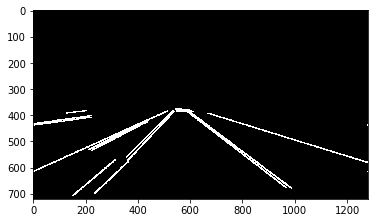

In [11]:
mask = cv2.imread('/path/train/mask/b1c66a42-6f7d68ca.png') 
plt.imshow(mask)

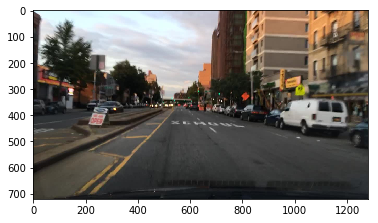

In [12]:
img = cv2.imread('/path/image2/b1c66a42-6f7d68ca.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


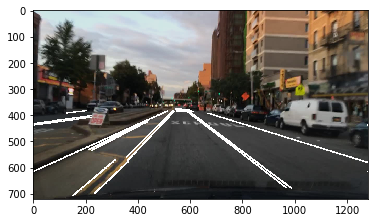

In [13]:
output = cv2.addWeighted(img, 0.9, mask, 1, 1)
# Opens a new window and displays the output frame
plt.imshow(output)

## Creating Generator

In orderto prevent loading all the images onto the disk at once a generator is created. The function would read a batch of images and their corresponding masks from the disk. Applies the following transformations:

-  Converting the mask into a binary image having channels equal to the number of classes
-  Resizing the image and teh maks to 720 x 1204
-  Applies canny operation to the image based on an input parameter

#### Creating function for Canny operation

In [12]:
def do_canny(frame):
    blur = cv2.GaussianBlur(frame, (5, 5), 0)
    blur = np.uint8(blur)
    canny = cv2.Canny(blur, 50, 100)
    return canny


#### Creating the generator body

In [13]:

def generator(image_path, mask_path, batch_size, input_height, input_width, labels, input_type):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.jpg"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
       
    assert len( images ) == len(segmentations)

    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range(batch_size) :
            im , seg = next(zipped)
            #reading image
            img = cv2.imread(im)[:,:,::-1]
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            
            #Applying canny operation if asked for
            if(input_type =='canny'):
                img = do_canny(img)
                img[0:250, :]=0
                img = np.expand_dims(img, axis=2)
            
            #Scaling the input image
            img = img.astype(np.float32)
            img = img/255.0
            
            X.append(img)
            
            #reading the mask
            img1 = cv2.imread(seg, 0)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            seg_labels = np.zeros((input_height , input_width  , len(labels)))
            
            #Transforming into binary
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
              
            Y.append(seg_labels)
            
        yield np.array(X) , np.array(Y)
    

## Enet Architecture 
 
 
The Enet architecture contains of five major regions wherein the first three belong to the encoder while teh last two to the decoder. In the same spirit the functions for encoder & decoder have been defined sepertely. The same are called in the main function repeatedly to create the model.

-  In order to decrease the number of parameters a bottleneck implements a series of operations. Firstly, the input is convolved with a 1x1 kernel to reduce the number of channels followed by the main operation. Thus, reducing the number of calculations to be performed. The output is again convolved with a 1x1 convolution to produce back the original number of channels. To regularize the output, a dropout layer is added.  Finally, a skip connection from the input is added back to the output to preserve spatial information.	
	
-  In case the bottleneck is down-sampling the 1x1 convolution in the bottleneck is replaced with that of having a kernel of 2x2 and a stride of 2x2 whereas a maxpooling layer is added to the skip connection to match the size of the output from the other branch. 

-  On the other hand, if the bottleneck is up-sampling the main convolution in the bottleneck is replaced with a transpose convolution while an upsampling layer is added to the skip connection to match the size of the output from the other branch. 


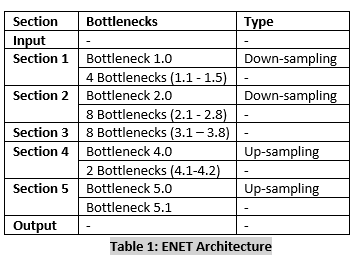

In [14]:
#encoder
def downsample_bottleneck(o, output_size , asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels
    
    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride =1
    
    o = Conv2D(output_size//4, (stride, stride),strides=(stride, stride), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv) 
    if asymmetric: 
        o = Conv2D(output_size//4, (1, asymmetric), padding='same', use_bias=False)(o)
        o = Conv2D(output_size//4, (asymmetric, 1), padding='same')(o)
    else:
        if dilated:
            o = Conv2D(output_size//4, (3, 3), dilation_rate=(dilated, dilated), padding='same')(o)
        else:
            o = Conv2D(output_size//4, (3, 3), padding='same')(o)
            
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1) 
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)  
    
    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch
    
    #performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)
    
        #performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o

In [15]:
# decoder
def upsample_bottleneck(o, output_size, upsample=0):
    
    other_branch = o
    
    #reducing the number of channel by 1x1 convolution
    o = Conv2D(output_size//4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)
    
    #Perfroming upsmapling if asked for otherwise performing normal convolution operation
    if upsample:
        o = Conv2DTranspose(output_size//4, kernel_size=(3, 3), strides=(2, 2), padding='same')(o)
    else:
        o = Conv2D(output_size//4, (3, 3), padding='same', use_bias=True)(o)
        
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)
    
    #Producing back the channels
    o = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(o)

    #Upsampling the other branch as well if upsampling is required
    if upsample:
            other_branch = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(other_branch)
            other_branch = BatchNormalization(momentum=0.1)(other_branch)
            other_branch = UpSampling2D(size=(2, 2))(other_branch)

    #Adding the two branches
    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation('relu')(o)

    return o

In [16]:
#Main function create the Model body

def ENet(n_classes, input_height, input_width, channels):
    
    #defining teh Input size
    img_input = Input(shape=(input_height, input_width, channels))
    
    
    ## Section Initial
    conv = Conv2D(13, (3, 3), padding='same', strides=(2,2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End
    
    ##Section 2 and 3 
    o = downsample_bottleneck(o, 64, downsample=True) # 1.1
    
    for _ in range(4): #1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True) #2.0
    
    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  #2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8
     
    ## Section 2 and 3 end
    
    
    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends
    
    #Section 5 
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    #section 5 ends

    o = Conv2DTranspose(filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)

    o = Activation('softmax')(o)
    model = Model(img_input, o)
    
    return model

## Training the model ---- RBG Image


In order to train the models Binary cross entropy has been used as the loss along with an Adam ooptimizer. The metrics used for performance checking are IoU and accuracy

The custom function to create a Mean IoU metric has been taken from the following source:

https://github.com/davidtvs/Keras-LinkNet/blob/master/metrics/miou.py


In [17]:
class MeanIoU(object):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
        # Wraps np_mean_iou method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float32)

    def np_mean_iou(self, y_true, y_pred):
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick from torchnet for bincounting 2 arrays together
        # https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 0

        return np.mean(iou).astype(np.float32)

## Train RBG with Binary loss

To train the model with RBG images model is created with an input having three channels. Similarly generators are created by defining that canny operation is not required.

In [18]:
#Creating the model by calling the min function for the Model

'''Parameters:

1. No of classes
2. Height of teh image
3. Width of the Image
3. No of channels in the Input'''

model = ENet(2, 704, 1280, 3)

**Defining the Generator and checking the output**

In [20]:
train_gen = generator('/path/train/image2/', '/path/train/mask/', 1 , 704, 1280, [0, 255], '')

In [21]:
valid_gen = generator('/path/valid/image2/', '/path/valid/mask/', 1 , 704, 1280, [0,  255], '')

In [22]:
test_gen = generator('/path/test/image2/', '/path/test/mask/', 1 , 704, 1280, [0, 255], '')

In [23]:
b,c = next(train_gen)

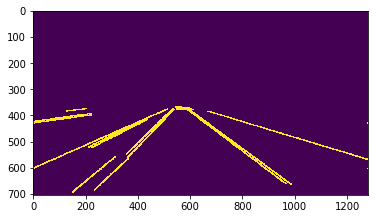

In [26]:
plt.imshow(c[0].argmax( axis=2 )*255)

(-0.5, 1279.5, 703.5, -0.5)

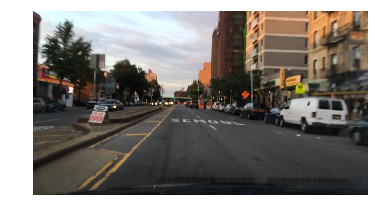

In [82]:
plt.imshow(b[0])
plt.axis('off')

**Training the model in three phases:** 
    1. One epoch
    2. Two Epoch
    3. two Epoch

In [28]:
miou_metric = MeanIoU(2)

model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001) , metrics=['accuracy', miou_metric.mean_iou] )
history1 = model.fit_generator( train_gen , 7000 , epochs=1, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_RGB_Binary_ENET_1')
print(history1.history)

Epoch 1/1
7000/7000 [==============================] - 1527s 218ms/step - loss: 0.0492 - acc: 0.9838 - mean_iou: 0.5276 - val_loss: 0.0511 - val_acc: 0.9867 - val_mean_iou: 0.5580
{'val_loss': [0.05105010258819918], 'val_acc': [0.986686228632927], 'val_mean_iou': [0.5579986671408017], 'loss': [0.04923367393465846], 'acc': [0.983839853222881], 'mean_iou': [0.5276271784028836]}


In [30]:
history2 = model.fit_generator( train_gen , 7000 , epochs=2, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_RGB_Binary_ENET_2')
print(history2.history)

Epoch 1/2
7000/7000 [==============================] - 1498s 214ms/step - loss: 0.0363 - acc: 0.9873 - mean_iou: 0.6109 - val_loss: 0.0403 - val_acc: 0.9876 - val_mean_iou: 0.5871
Epoch 2/2
7000/7000 [==============================] - 1494s 213ms/step - loss: 0.0336 - acc: 0.9878 - mean_iou: 0.6261 - val_loss: 0.0488 - val_acc: 0.9876 - val_mean_iou: 0.5971
{'val_loss': [0.04026187631970728, 0.048826041905022675], 'val_acc': [0.9876278534332911, 0.9876426808039347], 'val_mean_iou': [0.5871028563380242, 0.5971130350033442], 'loss': [0.03628999684183925, 0.03356850527369949], 'acc': [0.9872837491120611, 0.9878024738175528], 'mean_iou': [0.6108627825421946, 0.6260826824903488]}


In [31]:
history3 = model.fit_generator( train_gen , 7000 , epochs=2, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_RGB_Binary_ENET_3')
print(history3.history)

Epoch 1/2
7000/7000 [==============================] - 1498s 214ms/step - loss: 0.0319 - acc: 0.9881 - mean_iou: 0.6361 - val_loss: 0.0415 - val_acc: 0.9877 - val_mean_iou: 0.6039
Epoch 2/2
7000/7000 [==============================] - 1496s 214ms/step - loss: 0.0308 - acc: 0.9884 - mean_iou: 0.6430 - val_loss: 0.0536 - val_acc: 0.9878 - val_mean_iou: 0.5933
{'val_loss': [0.04149734723007229, 0.053638489886997834], 'val_acc': [0.9877332723140717, 0.9877646061579386], 'val_mean_iou': [0.6038576969703039, 0.5932573478420575], 'loss': [0.03193768772378098, 0.0308168362647453], 'acc': [0.988139931338174, 0.9883689182230404], 'mean_iou': [0.6360619712259088, 0.6430319427634988]}


#### Plotting the evolution of metrics for training and validation with Epoch

In [33]:
train_acc = history1.history['acc'] + history2.history['acc']+history3.history['acc']
train_loss = history1.history['loss'] + history2.history['loss'] + history3.history['loss'] 
train_iou = history1.history['mean_iou'] + history2.history['mean_iou'] + history3.history['mean_iou']
val_acc = history1.history['val_acc'] + history2.history['val_acc'] + history3.history['val_acc']
val_loss = history1.history['val_loss'] + history2.history['val_loss'] +  history3.history['val_loss'] 
val_iou = history1.history['val_mean_iou'] + history2.history['val_mean_iou'] + history3.history['val_mean_iou'] 

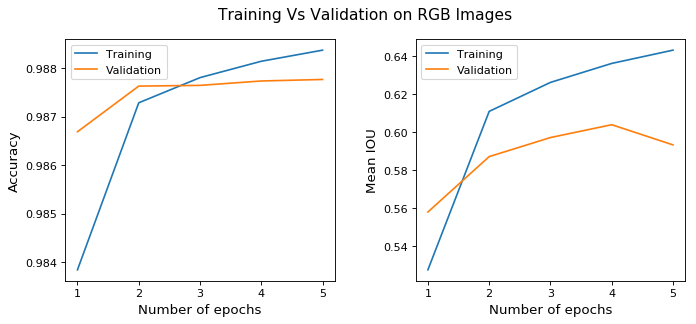

In [7]:
fig = plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
fig. suptitle('Training Vs Validation on RGB Images',  fontsize = 14)
plt.subplot(1,2,1)
plt.plot([1,2,3,4,5], train_acc,label = 'Training' )
plt.plot([1,2,3,4,5],val_acc, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()

plt.subplot(1,2,2)
plt.plot([1,2,3,4,5],train_iou, label = 'Training')
plt.plot([1,2,3,4,5],val_iou, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Mean IOU', fontsize = 12)
plt.subplots_adjust(wspace =0.3)
plt.legend()

In [1]:
#reveiwing prediction for the model

Solve time: 0.0939 seconds


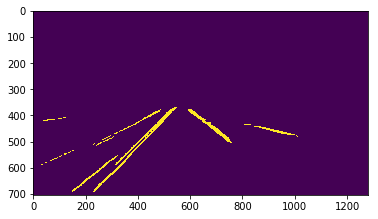

In [36]:
t0 = time.time()
plt.imshow(model.predict(b)[0].argmax(axis=2))
t1 = time.time()
print('Solve time: {:.4f} seconds'.format(round(t1 - t0, 4)))

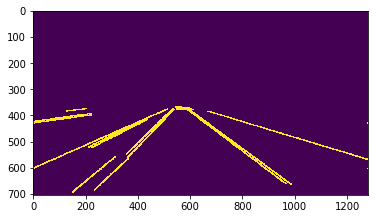

In [37]:
plt.imshow(c[0].argmax(axis=2))

## Train Model ----- CANNY Image

To train the model with Canny images model is created with an input having 1 channel. Similarly generators are created by defining that canny operation is required.

In [38]:
#Creating the model by calling the min function for the Model

'''Parameters:

1. No of classes
2. Height of teh image
3. Width of the Image
3. No of channels in the Input'''

model = ENet(2, 704, 1280, 1)

**Defining the Generator and checking the output**

In [40]:
train_gen = generator('/path/train/image2/', '/jpath/train/mask/', 1 , 704, 1280, [0, 255], 'canny')

In [41]:
valid_gen = generator('/path/valid/image2/', '/path/valid/mask/', 1 , 704, 1280, [0,  255], 'canny')

In [42]:
test_gen = generator('/path/test/image2/', '/path/test/mask/', 1 , 704, 1280, [0, 255], 'canny')

In [43]:
b,c = next(train_gen)

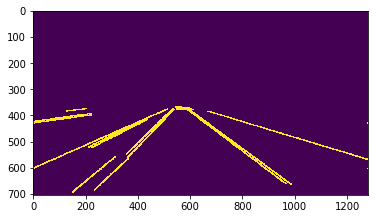

In [45]:
plt.imshow(c[0].argmax( axis=2 )*255)

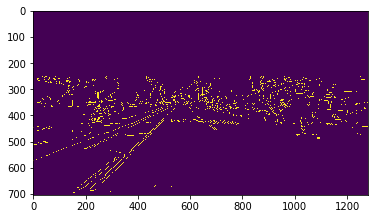

In [46]:
plt.imshow(np.squeeze(b[0]))

**Training the model in three phases:**

1. One epoch
2. Two Epoch
3. two Epoch

In [49]:
miou_metric = MeanIoU(2)

model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001) , metrics=['accuracy', miou_metric.mean_iou] )
history4 = model.fit_generator( train_gen , 7000 , epochs=1, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_CANNY_Binary_ENET_1')
print(history4.history)

Epoch 1/1
7000/7000 [==============================] - 1519s 217ms/step - loss: 0.0502 - acc: 0.9854 - mean_iou: 0.5269 - val_loss: 0.0487 - val_acc: 0.9850 - val_mean_iou: 0.5935
{'val_loss': [0.048661930362383525], 'val_acc': [0.9849930335680643], 'val_mean_iou': [0.593501502652963], 'loss': [0.050176010190475996], 'acc': [0.9853816784705435], 'mean_iou': [0.5269489298292569]}


In [50]:
history5 = model.fit_generator( train_gen , 7000 , epochs=2, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_CANNY_Binary_ENET_2')
print(history5.history)

Epoch 1/2
7000/7000 [==============================] - 1500s 214ms/step - loss: 0.0448 - acc: 0.9864 - mean_iou: 0.5756 - val_loss: 0.0439 - val_acc: 0.9866 - val_mean_iou: 0.5554
Epoch 2/2
7000/7000 [==============================] - 1499s 214ms/step - loss: 0.0426 - acc: 0.9868 - mean_iou: 0.5858 - val_loss: 0.0452 - val_acc: 0.9865 - val_mean_iou: 0.5567
{'val_loss': [0.04388662411202677, 0.04519886971109857], 'val_acc': [0.9865688322782517, 0.9865367824633916], 'val_mean_iou': [0.5554256654580434, 0.556656980117162], 'loss': [0.04477551958922829, 0.04261863351905985], 'acc': [0.9864392775978361, 0.9867800010102136], 'mean_iou': [0.5755579810951438, 0.5858161866622311]}


In [51]:
history6 = model.fit_generator( train_gen , 7000 , epochs=2, validation_data=valid_gen, validation_steps = 1500 )
model.save('Assignment3_CANNY_Binary_ENET_3')
print(history6.history)

Epoch 1/2
7000/7000 [==============================] - 1502s 215ms/step - loss: 0.0412 - acc: 0.9870 - mean_iou: 0.5920 - val_loss: 0.0445 - val_acc: 0.9867 - val_mean_iou: 0.5600
Epoch 2/2
7000/7000 [==============================] - 1501s 214ms/step - loss: 0.0402 - acc: 0.9872 - mean_iou: 0.5967 - val_loss: 0.0480 - val_acc: 0.9864 - val_mean_iou: 0.5807
{'val_loss': [0.04445633818748562, 0.048033274802612144], 'val_acc': [0.9867360957860947, 0.9863972605069479], 'val_mean_iou': [0.5600125573476156, 0.580737158258756], 'loss': [0.04119447003451309, 0.04020820592322187], 'acc': [0.9869956034336771, 0.9871594486832619], 'mean_iou': [0.5920276154237134, 0.5967121077094759]}


Solve time: 0.0930 seconds


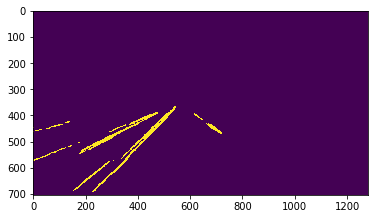

In [61]:
t0 = time.time()
plt.imshow(model.predict(b)[0].argmax(axis=2))
t1 = time.time()
print('Solve time: {:.4f} seconds'.format(round(t1 - t0, 4)))

#### Plotting the evolution of metrics for training and validation with Epoch

In [62]:
train_acc = history4.history['acc'] + history5.history['acc']+history6.history['acc']
train_loss = history4.history['loss'] + history5.history['loss'] + history6.history['loss'] 
train_iou = history4.history['mean_iou'] + history5.history['mean_iou'] + history6.history['mean_iou']
val_acc = history4.history['val_acc'] + history5.history['val_acc'] + history6.history['val_acc']
val_loss = history4.history['val_loss'] + history5.history['val_loss'] +  history6.history['val_loss'] 
val_iou = history4.history['val_mean_iou'] + history5.history['val_mean_iou'] + history6.history['val_mean_iou'] 

In [64]:
print(train_acc)
print(train_loss)
print(train_iou)
print(val_acc)
print(val_loss)
print(val_iou)

[0.9853816784705435, 0.9864392775978361, 0.9867800010102136, 0.9869956034336771, 0.9871594486832619]
[0.050176010190475996, 0.04477551958922829, 0.04261863351905985, 0.04119447003451309, 0.04020820592322187]
[0.5269489298292569, 0.5755579810951438, 0.5858161866622311, 0.5920276154237134, 0.5967121077094759]
[0.9849930335680643, 0.9865688322782517, 0.9865367824633916, 0.9867360957860947, 0.9863972605069479]
[0.048661930362383525, 0.04388662411202677, 0.04519886971109857, 0.04445633818748562, 0.048033274802612144]
[0.593501502652963, 0.5554256654580434, 0.556656980117162, 0.5600125573476156, 0.580737158258756]


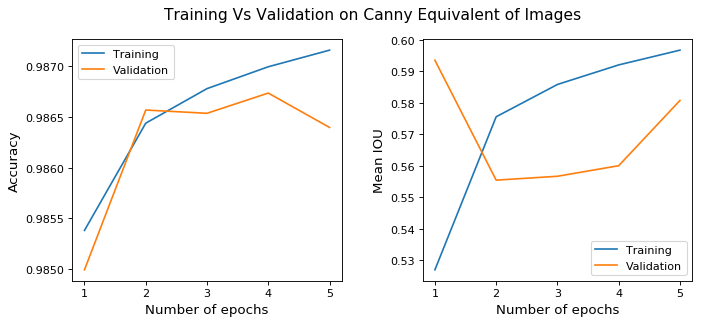

In [11]:
fig = plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
fig. suptitle('Training Vs Validation on Canny Equivalent of Images',  fontsize = 14)
plt.subplot(1,2,1)
plt.plot([1,2,3,4,5],train_acc,label = 'Training' )
plt.plot([1,2,3,4,5],val_acc, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()


plt.subplot(1,2,2)
plt.plot([1,2,3,4,5],train_iou, label = 'Training')
plt.plot([1,2,3,4,5],val_iou, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Mean IOU', fontsize = 12)
plt.subplots_adjust(wspace =0.3)
plt.legend()

In [ ]:
----------------------------------------------------------------------------------------------------------------------------------

## output for input example as it passes through the model 

The Model trained on RBG images is restored from disk and b is defined teh example imageto be studied

In [24]:
#restoring the model
model.load_weights('Assignment3_RGB_Binary_ENET_3')

In [26]:
#defining a function that treturns the output from an intermediate layer given an input to work on and the layer name

from keras import backend as K

l=[]
for i in model.layers:
    l.append(i.name)
    
def any_layer_output(x , output_layer_idx, filter_n):

    get_layer_output = K.function([model.layers[0].input],
                                      [model.layers[output_layer_idx].output])

    layer_output = get_layer_output([x])[0]
    return layer_output[0][:,:,filter_n]

**Output after every section in ENet is studied**

(-0.5, 319.5, 175.5, -0.5)

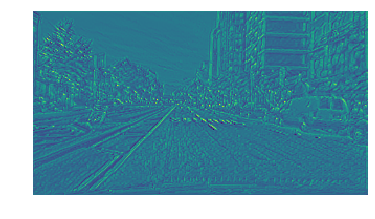

In [74]:
plt.imshow(any_layer_output(b, l.index('add_5'), 0))
plt.axis('off')

(-0.5, 159.5, 87.5, -0.5)

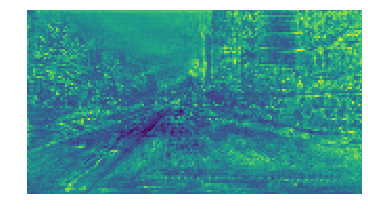

In [78]:
plt.imshow(any_layer_output(b, l.index('add_14'), 0))
plt.axis('off')

(-0.5, 159.5, 87.5, -0.5)

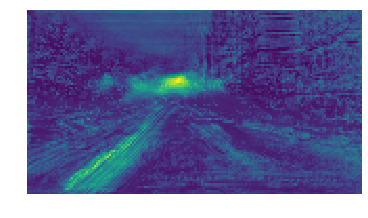

In [79]:
plt.imshow(any_layer_output(b, l.index('add_22'), 0))
plt.axis('off')

(-0.5, 319.5, 175.5, -0.5)

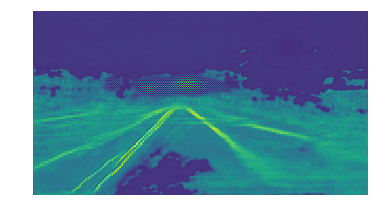

In [80]:
plt.imshow(any_layer_output(b, l.index('add_25'), 0))
plt.axis('off')

(-0.5, 639.5, 351.5, -0.5)

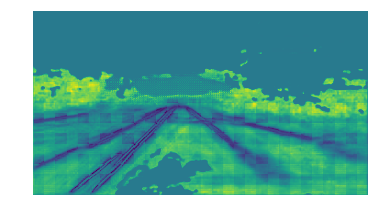

In [81]:
plt.imshow(any_layer_output(b, l.index('add_27'), 0))
plt.axis('off')

(-0.5, 1279.5, 703.5, -0.5)

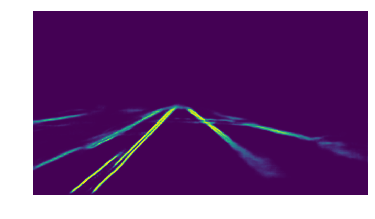

In [49]:
plt.imshow(any_layer_output(b, l.index('activation_16'), 1))
plt.axis('off')

## Model Evaluation

The Model is evaluated under different operating conditions as to be implemented in an autonomous vehcile teh modl should be able to make good prediction in teh direst of conditions

In [23]:
# A functin which reads the input from the disk and applies the required transformations is implemented

def read_img(img_name):
    img = cv2.imread('/path/test/image2/' + img_name + '.jpg')[:,:,::-1]
    img = cv2.resize(img, ( 1280 , 704 ),interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/255.0
    img = img[np.newaxis]

    return img

In [22]:
# A functin which reads the mask from the disk and applies the required transformations is implemented

def read_mask(img_name):
    img = cv2.imread('/path/test/mask/' + img_name + '.png')[:,:,0]
    img = cv2.resize(img, ( 1280 , 704 ),interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/255.0
    return img

In [19]:
# Afunction which calculates the accuracy, IoU and precision for the prediction is implemented

def calc_metric(num_classes, y_true, y_pred):
    
    target = y_true.ravel()
    predicted = y_pred.ravel()
    
    x = predicted + num_classes * target
    
    bincount_2d = np.bincount(x.astype(np.int32), minlength=num_classes**2)
    
    assert bincount_2d.size == num_classes**2
    
    conf = bincount_2d.reshape((num_classes, num_classes))

    true_positive = np.diag(conf)
    false_positive = np.sum(conf, 0) - true_positive
    false_negative = np.sum(conf, 1) - true_positive
    
    #print(false_positive)
    #print(false_negative)
    #print(conf)
    
    # Just in case we get a division by 0, ignore/hide the error and set the value to 0
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = true_positive / (true_positive + false_positive + false_negative)
        accuracy = np.sum(true_positive)/(np.sum(true_positive)+np.sum(false_negative))
        precision = true_positive/(true_positive+false_positive)
    
    iou[np.isnan(iou)] = 0
    precision[np.isnan(precision)] = 0
    
    return (np.mean(iou).astype(np.float32), accuracy, np.mean(precision))

Plotting the original image and True label along side the prediction. The values for metrics realized have also been included. 

IoU: 0.7017 Accuracy: 0.9858 Precision: 0.7445 


Text(0.5, 1.0, 'Prediction')

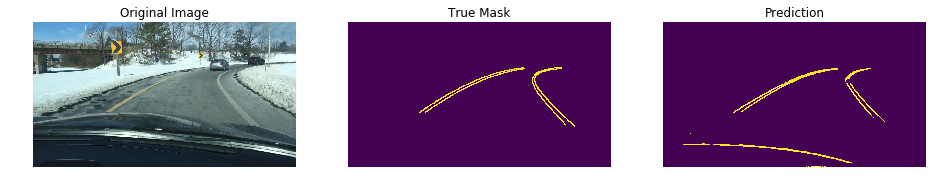

In [25]:
img = 'b92e15f8-bf91ff53'
y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')

IoU: 0.7440 Accuracy: 0.9720 Precision: 0.7890 


Text(0.5, 1.0, 'Prediction')

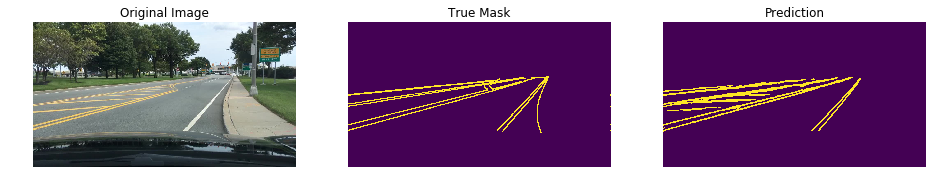

In [17]:
img = 'c4f8633c-a33316a8'
y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.7395 Accuracy: 0.9934 Precision: 0.9049 


Text(0.5, 1.0, 'Prediction')

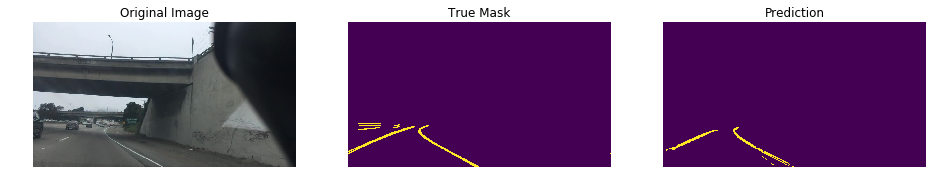

In [18]:
img = 'c7fe62b1-831805d0'
y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.8546 Accuracy: 0.9981 Precision: 0.9086 


Text(0.5, 1.0, 'Prediction')

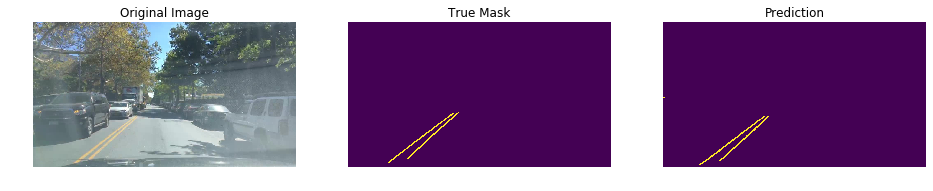

In [19]:
img = 'c4eb5462-ebd248b7'

y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.7888 Accuracy: 0.9953 Precision: 0.8414 


Text(0.5, 1.0, 'Prediction')

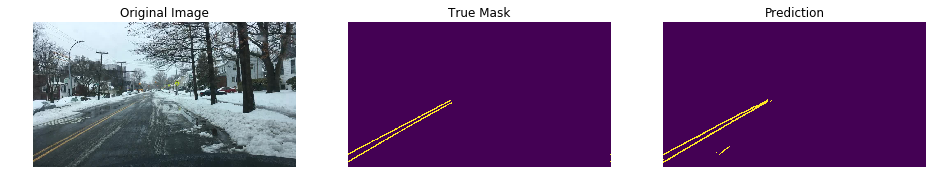

In [20]:
img = 'c8bd76fd-77472fba'

y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.7489 Accuracy: 0.9893 Precision: 0.8635 


Text(0.5, 1.0, 'Prediction')

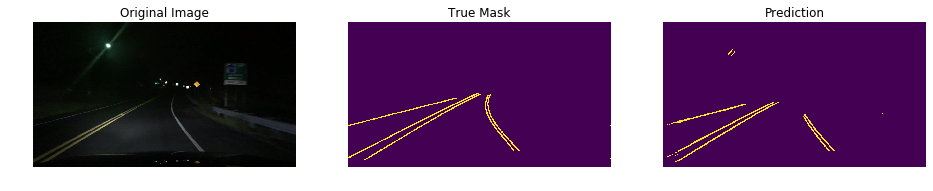

In [21]:
img = 'c7569602-82b4e54f'

y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.6940 Accuracy: 0.9813 Precision: 0.8421 


Text(0.5, 1.0, 'Prediction')

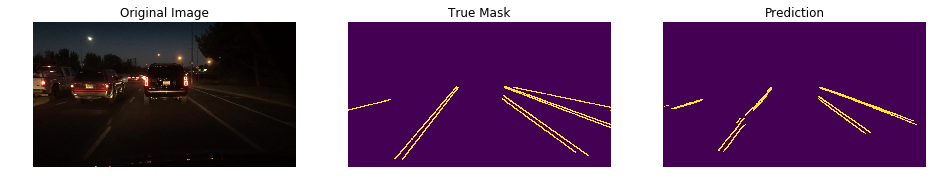

In [22]:
img = 'c3e87419-5b9ddce0'

y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')


IoU: 0.4961 Accuracy: 0.9922 Precision: 0.4962 


Text(0.5, 1.0, 'Prediction')

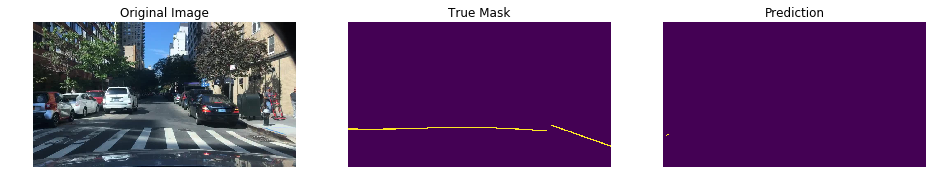

In [26]:
img = 'b9c7f347-97b374b1'

y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')

## Video Implementation

As an autonomous vehicle would be processing information using a video and not still images the model predictions were also visualized on a 10 sec video.

The size on disk for the video provided by Berkley was very large. Due to limited resources a video from github 'challenge.mp4' was utilized for the same.

The link to the source is : https://github.com/windowsub0406/SelfDrivingCarND/tree/master/SDC_project_1

In [27]:
# Function that given an input image performs the required transformations, makes predictions, superimposes original image and the prediction, and returns the same.

def vid_pipeline(img):
    global running_avg
    global index
    
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, ( 1280 , 704 ),interpolation=cv2.INTER_NEAREST)
    original = img
    img = img[np.newaxis]
    
    img = model.predict(img)[0]
    img = img.argmax( axis=2 )
    
    img_new = np.zeros((img.shape[0], img.shape[1], 3)) 

    img_new[:,:,0] =img
    img_new[:,:,1] =img
    img_new[:,:,2] =img

    output = cv2.addWeighted((original*255).astype(np.uint8), 0.9, (img_new*255).astype(np.uint8), 1, 1)
    return output

In [40]:
#moviepy API hass been used to extract frames from the video and tehn to concatente the preidtcions for the same.
from moviepy.editor import VideoFileClip
myclip = VideoFileClip('challenge.mp4')
output_vid = 'output.mp4'

clip = myclip.fl_image(vid_pipeline)

clip.write_videofile(output_vid, audio=False)


t:   1%|          | 2/251 [00:00<00:16, 15.31it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
Solve time: 0.7473 seconds
